In [39]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing import image
from keras.models import load_model

# Data preparation phase

In [40]:
#provide path of the radio graphs and nonradio graphs
train_xray_dir = os.path.join('datasets/CXR_NonCXR/chest_xrays')
train_nonxray_dir = os.path.join('datasets/CXR_NonCXR/non_chest_xrays')

In [41]:
#saving names of the image files in train_xray_name, train_nonxray_names
train_xray_names = os.listdir(train_xray_dir)
train_nonxray_names = os.listdir(train_nonxray_dir)

In [42]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# Index for iterating over images
pic_index = 0

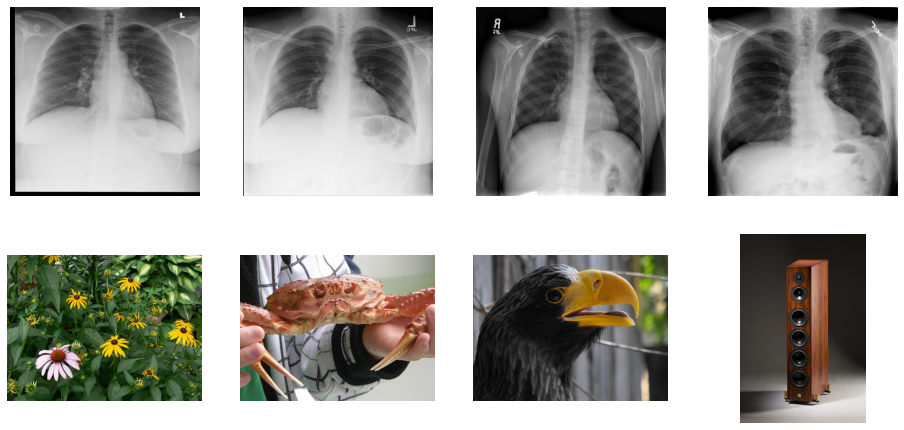

In [43]:
#displaying few images of xrays and non xrays
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 4
next_xray_pic = [os.path.join(train_xray_dir, fname) 
                for fname in train_xray_names[pic_index-4:pic_index]]
next_nonxray_pic = [os.path.join(train_nonxray_dir, fname) 
                for fname in train_nonxray_names[pic_index-4:pic_index]]

for i, img_path in enumerate(next_xray_pic + next_nonxray_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  #img = mpimg.imread(img_path)
  img=tf.keras.preprocessing.image.load_img(
    img_path, grayscale=False, color_mode='rgb', target_size=None,
    interpolation='nearest')

  plt.imshow(img)

plt.show()

In [44]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    'datasets/CXR_NonCXR',     #path of the dataset
    #labels="inferred",
    classes=['non_chest_xrays','chest_xrays'], #names of the classes inside the dataset path
    target_size=(200, 200),
    batch_size=120,
    class_mode='binary',
    subset='training') # training data

validation_generator = train_datagen.flow_from_directory(
    'datasets/CXR_NonCXR',    # same directory as training data
    #labels="inferred",
    classes=['non_chest_xrays','chest_xrays'],
    target_size=(200, 200),
    batch_size=19,
    class_mode='binary',
    subset='validation',
    shuffle=False)

Found 40000 images belonging to 2 classes.
Found 9999 images belonging to 2 classes.


# Training phase

In [45]:
#model
model = Sequential()
model.add(MobileNetV2(include_top = False, weights="imagenet", input_shape=(200, 200, 3)))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [47]:
model.compile(optimizer=RMSprop(lr=0.01), loss = 'binary_crossentropy', metrics = 'accuracy')

In [11]:
xray = model.fit(
      train_generator,
      steps_per_epoch=10,  
      epochs=10,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=10)

Epoch 1/10
10/10 [==============================] - 23s 2s/step - loss: 0.1886 - accuracy: 0.8933 - val_loss: 0.0119 - val_accuracy: 0.9947
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.0123 - accuracy: 0.9933 - val_loss: 0.0117 - val_accuracy: 0.9947
Epoch 3/10
10/10 [==============================] - 22s 2s/step - loss: 0.0057 - accuracy: 0.9992 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 22s 2s/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.0413 - val_accuracy: 0.9842
Epoch 5/10
10/10 [==============================] - 22s 2s/step - loss: 0.0057 - accuracy: 0.9983 - val_loss: 0.0076 - val_accuracy: 0.9947
Epoch 6/10
10/10 [==============================] - 22s 2s/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 5.3144e-04 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 22s 2s/step - loss: 0.0094 - accuracy: 0.9950 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 8/10
10/10

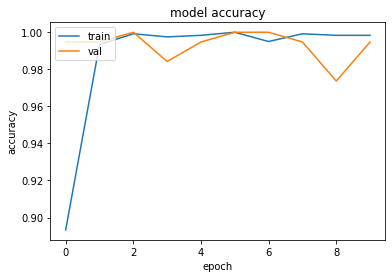

<Figure size 432x288 with 0 Axes>

In [19]:
#plotting training accuracy and validation accuracy
plt.plot(xray.history['accuracy'])
plt.plot(xray.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig("chest_Xray_binary_accuracy.png", bbox_inches='tight')

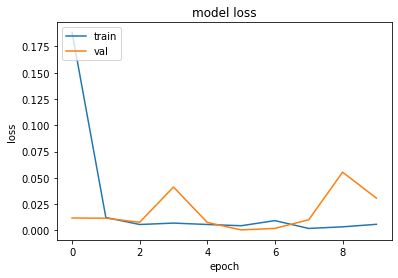

<Figure size 432x288 with 0 Axes>

In [20]:
# plotting training loss and validation loss
plt.plot(xray.history['loss'])
plt.plot(xray.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig("chest_Xray_binary_loss.png", bbox_inches='tight')

In [16]:
#save model and weights
model.save_weights("webapp/saved_models/chest_xray_binary_weights.h5")
model.save("webapp/saved_models/chest_xray_binary.h5")

# Testing phase

In [17]:
model.evaluate(validation_generator)

527/527 [==============================] - 176s 333ms/step - loss: 0.0167 - accuracy: 0.9941


[0.016693873330950737, 0.9940994381904602]

In [18]:
STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size
validation_generator.reset()
preds = model.predict(validation_generator,
                      verbose=1)

527/527 [==============================] - 160s 303ms/step


In [21]:
#ROC curve
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)

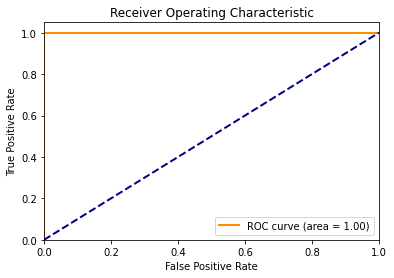

<Figure size 432x288 with 0 Axes>

In [22]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
plt.savefig("chest_Xray_binary_roc.png", bbox_inches='tight')

# prediction (user input)

In [48]:
# give the path of the saved models
loaded_model=load_model("webapp/saved_models/chest_xray_binary.h5")

[[1.]]
 is a xray


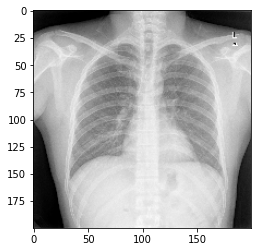

In [49]:
# predicting images
#provide path of the image
path = "images/lung_xray_2/.png"
img = image.load_img(path, target_size=(200, 200))
x = image.img_to_array(img)
plt.imshow(x/255.)
x = np.expand_dims(x/255., axis=0)
images = np.vstack([x])
classes = loaded_model.predict(images)
print(classes)
if classes[0]<0.5:
    print(" is not a xray")
else:
    print(" is a xray")